In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime, timedelta
from ast import literal_eval

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
from pathlib import Path
import shutil

drive_dir = Path('drive')
drive.mount(str(drive_dir.resolve()), force_remount=True)

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/noaa_satellite_data.csv')

In [ ]:
!pip install haversine

In [ ]:
import csv
from pyorbital.orbital import Orbital
import datetime

# Define the list of NOAA satellite names
noaa_satellites = [
    'NOAA 1',
    'NOAA 2',
    'NOAA 3',
    'NOAA 4',
    'NOAA 5',
    'NOAA 6',
    'NOAA 7',
    'NOAA 8',
    'NOAA 9',
    'NOAA 10',
    'NOAA 11',
    'NOAA 12',
    'NOAA 13',
    'NOAA 14',
    'NOAA 15',
    'NOAA 16',
    'NOAA 17',
    'NOAA 18',
    'NOAA 19',
    'NOAA 20',
]

# Load the TLE data from the text file
tle_data = {}

with open('tle.txt', 'r') as tle_file:
    lines = tle_file.readlines()
    i = 0
    while i < len(lines):
        sat_name = lines[i].strip()
        tle_line1 = lines[i + 1].strip()
        tle_line2 = lines[i + 2].strip()
        tle_data[sat_name] = (tle_line1, tle_line2)
        i += 3

# Get the current time
current_time = datetime.datetime.utcnow()

# Create a dataset for the past 24 hours with the same timestamps
dataset = []

for i in range(24 * 60):  # 24 hours * 60 minutes
    data_point = {'Time': current_time}

    for sat_name in noaa_satellites:
        try:
            tle_lines = tle_data.get(sat_name)
            if tle_lines:
                sat = Orbital(sat_name, line1=tle_lines[0], line2=tle_lines[1])
                position = sat.get_lonlatalt(current_time)
                data_point[sat_name] = {
                    'Longitude': position[0],
                    'Latitude': position[1],
                    'Altitude': position[2],
                }
            else:
                print(f"No TLE data found for {sat_name}. Skipping...")
        except ValueError as e:
            print(f"Error fetching data for {sat_name}: {e}. Skipping...")

    dataset.append(data_point)
    current_time -= datetime.timedelta(minutes=1)  # Move back one minute

# Save the dataset to a CSV file
csv_filename = 'noaa_satellite_data.csv'

with open(csv_filename, mode='w', newline='') as csv_file:
    fieldnames = ['Time'] + noaa_satellites
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    writer.writeheader()
    for data_point in dataset:
        writer.writerow(data_point)

print(f'Data has been saved to {csv_filename}.')

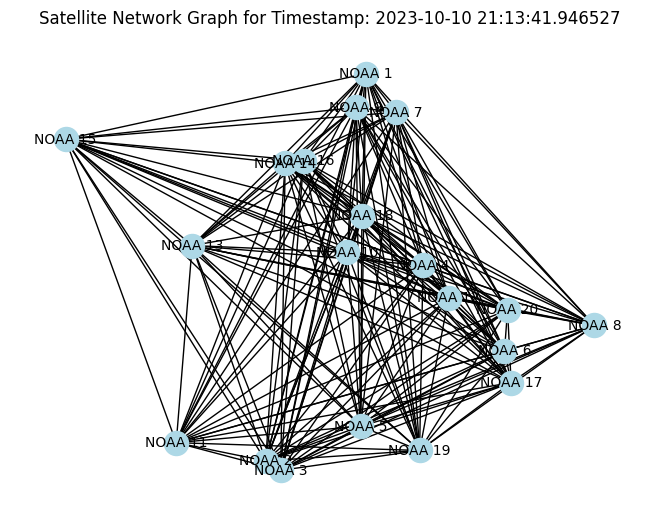

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from haversine import haversine
import ast
# Read the CSV file into a Pandas DataFrame
# df = pd.read_csv('noaa_satellite_data.csv')

# Select a specific timestamp (row)
selected_timestamp = "2023-10-10 21:13:41.946527"
selected_row = df[df['Time'] == selected_timestamp]

# Create an empty NetworkX graph
G = nx.Graph()

# Add nodes for each satellite
satellite_columns = selected_row.columns[1:]  # Exclude the timestamp column
for satellite in satellite_columns:
    G.add_node(satellite)

# Calculate distances and add edges for the selected row
for i in range(len(satellite_columns)):
    for j in range(i + 1, len(satellite_columns)):
        satellite1 = satellite_columns[i]
        satellite2 = satellite_columns[j]
        # Extract the latitude and longitude for both satellites and parse them
        coord1 = ast.literal_eval(selected_row[satellite1].values[0])
        coord2 = ast.literal_eval(selected_row[satellite2].values[0])
        lat1, lon1 = coord1['Latitude'], coord1['Longitude']
        lat2, lon2 = coord2['Latitude'], coord2['Longitude']
        # Calculate the distance using the haversine formula
        distance = haversine((lat1, lon1), (lat2, lon2))
        G.add_edge(satellite1, satellite2, weight=distance)

# Create a layout for the nodes
layout = nx.spring_layout(G)

# Draw the nodes and labels
nx.draw(G, layout, with_labels=True, node_size=300, node_color='lightblue', font_size=10)

# # Draw the edges with labels
# edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges}
# nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=edge_labels, font_size=8)

# Display the graph
plt.title(f"Satellite Network Graph for Timestamp: {selected_timestamp}")
plt.show()

In [ ]:
for column in df.columns[1:]:
    df[column] = df[column].apply(literal_eval)

In [ ]:
base_station_location = {
    'Latitude': 37.7749,  # Sample latitude for San Francisco, CA
    'Longitude': -122.4194,  # Sample longitude for San Francisco, CA
    'Altitude': 10.0  # Sample altitude in meters
}

In [ ]:
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(coord1, coord2):
    R = 6371000.0

    if isinstance(coord1, dict):
        lat_key, lon_key = 'Latitude', 'Longitude'
        lat1, lon1 = radians(coord1.get(lat_key, 0.0)), radians(coord1.get(lon_key, 0.0))
    elif isinstance(coord1, float):
        lat1, lon1 = radians(coord1), 0.0
    else:
        raise ValueError("Invalid coordinate format")

    lat2, lon2 = radians(coord2['Latitude']), radians(coord2['Longitude'])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance


In [ ]:
satellite_columns = df.columns[1:]

for satellite_column in satellite_columns:
    df[f'DistanceToBase_{satellite_column}'] = df.apply(lambda row: haversine_distance(row[satellite_column], base_station_location), axis=1)


NameError: name 'base_station_location' is not defined

In [ ]:
selected_columns = ['Time']+[f'DistanceToBase_NOAA {satellite}' for satellite in range(1, 21)]
df_selected = df[selected_columns]
df_selected.to_csv('data.csv', index=False)


NameError: name 'df' is not defined

In [ ]:
df_selected = pd.read_csv('data.csv')
df_selected

,Time,DistanceToBase_NOAA 1,DistanceToBase_NOAA 2,DistanceToBase_NOAA 3,DistanceToBase_NOAA 4,DistanceToBase_NOAA 5,DistanceToBase_NOAA 6,DistanceToBase_NOAA 7,DistanceToBase_NOAA 8,DistanceToBase_NOAA 9,...,DistanceToBase_NOAA 11,DistanceToBase_NOAA 12,DistanceToBase_NOAA 13,DistanceToBase_NOAA 14,DistanceToBase_NOAA 15,DistanceToBase_NOAA 16,DistanceToBase_NOAA 17,DistanceToBase_NOAA 18,DistanceToBase_NOAA 19,DistanceToBase_NOAA 20
0,2023-12-17 05:56:49.524078,6.099770e+06,1.043984e+07,1.226009e+07,6.701514e+06,1.098280e+07,1.368145e+07,4.682919e+06,1.348571e+07,9.650846e+06,...,1.032450e+07,7.890325e+06,1.341740e+07,1.013824e+07,3.661499e+06,4.633963e+06,5.897977e+06,6.863589e+06,5.233161e+06,9.732988e+06
1,2023-12-17 05:56:48.524078,6.094140e+06,1.044263e+07,1.226225e+07,6.701170e+06,1.098076e+07,1.367745e+07,4.676556e+06,1.348392e+07,9.647614e+06,...,1.032160e+07,7.893149e+06,1.341777e+07,1.013425e+07,3.660890e+06,4.639474e+06,5.898299e+06,6.870231e+06,5.239196e+06,9.737309e+06
2,2023-12-17 05:56:47.524078,6.088510e+06,1.044542e+07,1.226440e+07,6.700830e+06,1.097873e+07,1.367346e+07,4.670193e+06,1.348213e+07,9.644381e+06,...,1.031871e+07,7.895974e+06,1.341815e+07,1.013026e+07,3.660292e+06,4.644987e+06,5.898626e+06,6.876873e+06,5.245233e+06,9.741629e+06
3,2023-12-17 05:56:46.524078,6.082880e+06,1.044821e+07,1.226655e+07,6.700491e+06,1.097669e+07,1.366946e+07,4.663831e+06,1.348034e+07,9.641148e+06,...,1.031581e+07,7.898801e+06,1.341852e+07,1.012628e+07,3.659703e+06,4.650503e+06,5.898957e+06,6.883515e+06,5.251270e+06,9.745950e+06
4,2023-12-17 05:56:45.524078,6.077250e+06,1.045100e+07,1.226871e+07,6.700156e+06,1.097466e+07,1.366546e+07,4.657469e+06,1.347854e+07,9.637915e+06,...,1.031292e+07,7.901630e+06,1.341888e+07,1.012229e+07,3.659125e+06,4.656021e+06,5.899292e+06,6.890157e+06,5.257309e+06,9.750270e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604795,2023-12-10 05:56:54.524078,1.600454e+07,6.640344e+06,8.254141e+06,1.141327e+07,1.092082e+07,4.608904e+06,2.458642e+06,1.369870e+07,7.685975e+06,...,9.821701e+06,6.636860e+06,1.173789e+07,1.151612e+07,8.633527e+06,2.197114e+06,1.058740e+07,1.301067e+06,2.067670e+06,1.445213e+07
604796,2023-12-10 05:56:53.524078,1.599927e+07,6.639219e+06,8.256330e+06,1.141097e+07,1.092284e+07,4.607068e+06,2.464144e+06,1.369736e+07,7.683301e+06,...,9.818807e+06,6.634979e+06,1.174052e+07,1.151235e+07,8.628091e+06,2.195898e+06,1.058369e+07,1.307426e+06,2.063816e+06,1.444991e+07
604797,2023-12-10 05:56:52.524078,1.599400e+07,6.638096e+06,8.258521e+06,1.140867e+07,1.092487e+07,4.605238e+06,2.469650e+06,1.369601e+07,7.680629e+06,...,9.815913e+06,6.633102e+06,1.174315e+07,1.150857e+07,8.622655e+06,2.194701e+06,1.057997e+07,1.313788e+06,2.059974e+06,1.444767e+07
604798,2023-12-10 05:56:51.524078,1.598873e+07,6.636976e+06,8.260713e+06,1.140636e+07,1.092689e+07,4.603415e+06,2.475163e+06,1.369466e+07,7.677958e+06,...,9.813019e+06,6.631227e+06,1.174578e+07,1.150479e+07,8.617220e+06,2.193521e+06,1.057626e+07,1.320152e+06,2.056146e+06,1.444544e+07


In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
train_data, test_data = train_test_split(df_selected, test_size=0.2, shuffle=False)
print(len(train_data))
print(len(test_data))

483840
120960


In [ ]:
# Normalization
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data.iloc[:, 1:])
test_data_normalized = scaler.transform(test_data.iloc[:, 1:])


In [ ]:
train_data_normalized

array([[0.30340313, 0.52222786, 0.60996784, ..., 0.34376221, 0.26018293,
        0.48771424],
       [0.30312086, 0.52236769, 0.61007651, ..., 0.34409621, 0.26048525,
        0.4879328 ],
       [0.3028386 , 0.52250753, 0.61018514, ..., 0.34443021, 0.26078762,
        0.48815135],
       ...,
       [0.65650955, 0.73157828, 0.09714433, ..., 0.7620853 , 0.86712858,
        0.72592715],
       [0.65674661, 0.73130875, 0.09713503, ..., 0.76201123, 0.86712566,
        0.7257703 ],
       [0.6569836 , 0.73103918, 0.09712656, ..., 0.76193685, 0.86712201,
        0.72561317]])

In [ ]:
# Sequence Generation
def generate_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i+sequence_length]
        sequences.append(sequence)
    return np.array(sequences)

In [ ]:
sequence_length = 50  # Adjust as needed
X_train = generate_sequences(train_data_normalized, sequence_length)
y_train = train_data_normalized[sequence_length:]

X_test = generate_sequences(test_data_normalized, sequence_length)
y_test = test_data_normalized[sequence_length:]

In [ ]:
# Build the LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 20)))  # Assuming 20 satellites
model.add(Dense(20))  # Output layer with 20 neurons for each satellite
model.compile(optimizer='adam', loss='mean_squared_error')
# from tensorflow.keras.optimizers import Adam
# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(sequence_length, 20), return_sequences=True))
# model.add(LSTM(50, activation='relu'))
# model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 20), dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(20, activation='softmax'))
# optimizer = Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='mean_squared_error')

In [ ]:
from joblib import dump, load

# # Assuming 'model' is your trained machine learning model
# # Save the model to a file
# dump(model, 'model.joblib')

# # To load the model back
model = load('model.joblib')


In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=32)
# history = model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_test, y_test))

In [ ]:
# Validation
predicted_distances = model.predict(X_test)
predicted_distances = scaler.inverse_transform(predicted_distances)


3779/3779 [==============================] - 42s 11ms/step


In [ ]:
# Identify Closest Satellite for each time instance
true_closest_satellite_ids = np.argmin(test_data.iloc[sequence_length:, 1:].values, axis=1) + 1
predicted_closest_satellite_ids = np.argmin(predicted_distances, axis=1) + 1

# Calculate Classification Accuracy
accuracy = np.sum(true_closest_satellite_ids == predicted_closest_satellite_ids) / len(true_closest_satellite_ids)

print(f'Classification Accuracy: {accuracy * 100:.2f}%')

Classification Accuracy: 94.51%


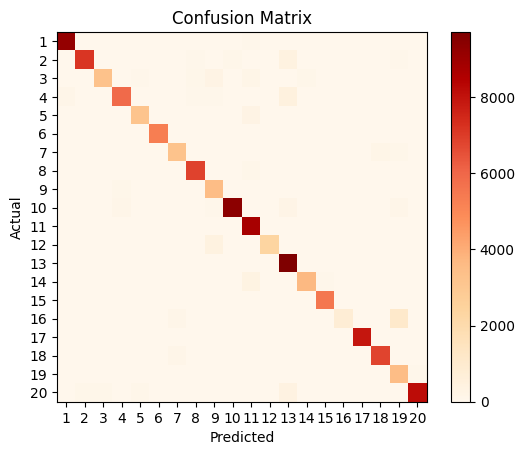

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(true_closest_satellite_ids, predicted_closest_satellite_ids)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.OrRd, origin='upper')  # Use OrRd colormap and upper origin
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(20), np.arange(1, 21))  # Assuming 20 satellites
plt.yticks(np.arange(20), np.arange(1, 21))  # Assuming 20 satellites
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.gca().set_facecolor('white')
plt.show()

In [ ]:
print(len(predicted_distances))

120910


In [ ]:
print(len(predicted_distances[1]))

20


In [ ]:
# Identify Closest Satellite
closest_satellites_indices = np.argmin(predicted_distances[-1])  # Choose the last time instance
closest_satellite_id = closest_satellites_indices + 1  # Indexing starts from 0
top_10_closest_satellites_indices = np.argsort(predicted_distances[-1])[:10]
print("Closest Satellite ID:", closest_satellite_id)

Closest Satellite ID: 18


In [ ]:
pnl = []
for i in range(188):
  # Identify Closest Satellite
  val = -i-1
  closest_satellites_indices = np.argmin(predicted_distances[val])  # Choose the last time instance
  closest_satellite_id = closest_satellites_indices + 1  # Indexing starts from 0
  pnl.append(closest_satellite_id)

pnl.reverse()
print(len(pnl))


188


In [ ]:
# Specify the range of row indices
start_index = 1252
end_index = 1439  # Adjust this based on your requirement
nl = []
for row_index in range(start_index, end_index + 1):
    # Exclude the 'Time' column
    row_values = df.iloc[row_index].drop('Time')

    # Check for non-numeric or NaN values and convert to numeric
    row_values_numeric = pd.to_numeric(row_values, errors='coerce')

    # Find the minimum value and corresponding column name
    min_value_column = row_values_numeric.idxmin()
    x = min_value_column.split(" ")
    nl.append(int(x[1]))

print(len(nl))

188


In [ ]:
print(pnl)
print(nl)
t=0
f=0
for i in range(188):
  if pnl[i]==nl[i]:
    t+=1
  else:
    f+=1

print(t) #correct predictions count
print(f) #incorrect predictions count

[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
satellite_frequencies = {}
satellite_frequencies[1] = 137.2
satellite_frequencies[2] = 137.225
satellite_frequencies[3] = 137.25
satellite_frequencies[4] = 137.2875
satellite_frequencies[5] = 137.315
satellite_frequencies[6] = 137.44
satellite_frequencies[7] = 137.46
satellite_frequencies[8] = 137.6625
satellite_frequencies[9] = 137.6875
satellite_frequencies[10] = 137.7125
satellite_frequencies[11] = 137.7375
satellite_frequencies[12] = 137.8
satellite_frequencies[13] = 137.910
satellite_frequencies[14] = 137.56
satellite_frequencies[15] = 137.35
satellite_frequencies[16] = 137.62
satellite_frequencies[17] = 137.35
satellite_frequencies[18] = 137.9125
satellite_frequencies[19] = 137.77
satellite_frequencies[20] = 137.1

In [ ]:
# My novel handover approach
import random
import time
from datetime import datetime
import pdb

class Satellite:
    def __init__(self, id, base_station_id, bandwidth):
        self.id = id
        self.distance = 0
        self.available = True
        self.last_handover_time = None
        self.path_loss = 0
        self.base_station_id = base_station_id
        self.bandwidth = bandwidth
        self.connected_uess = []

    def connect_ue(self, ue):
        if ue not in self.connected_uess:
          self.connected_uess.append(ue)

    def disconnect_ue(self, ue):
        if ue in self.connected_uess:
          self.connected_uess.remove(ue)

    def calculate_load(self):
        return self.bandwidth - sum([ue.bandwidth for ue in self.connected_uess])

    def handover(self):
        self.last_handover_time = datetime.now()


class UE:
    def __init__(self, id, bandwidth):
        self.id = id
        self.bandwidth = bandwidth

def pathLoss(satId, distance):
  temp = (4*3.14*(distance)*satellite_frequencies[satId])/3
  return temp*temp

def satDistance(satellite_id):
  current_time = datetime.now()
  last_timestamp = test_data['Time'].iloc[-1]
  last_timestamp = datetime.strptime(last_timestamp, "%Y-%m-%d %H:%M:%S.%f")

  next_timestamp = last_timestamp + (current_time - last_timestamp)

  next_sequence = test_data_normalized[-sequence_length:]
  next_sequence = np.expand_dims(next_sequence, axis=0)

  predicted_distance = model.predict(next_sequence)
  predicted_distance = scaler.inverse_transform(predicted_distance)
  predicted_distance = predicted_distance[0, satellite_id-1]

  return predicted_distance

def SatelliteFarFromBaseStation(satId, thresholdSat):
  if satDistance(satId) > satDistance(thresholdSat):
    print(f"Satellite {satId} reached the threshold distance.")
    return True
  return False

def handover(satellites):
  for sat in satellites:
    sat.path_loss = pathLoss(sat.id, sat.distance)
  sorted_satellites = sorted(satellites, key=lambda x: x.path_loss)
  sorted_satellites = sorted(sorted_satellites, key=lambda x: x.calculate_load(), reverse=True)

  for sat in sorted_satellites:
    if sat.available:
      print(f"Handover to satellite {sat.id} initiated.")
      start_time = datetime.now()
      sat.handover()
      print(f"Handover to satellite {sat.id} successful!")
      end_time = datetime.now()
      handover_latency = (end_time - start_time).total_seconds()
      print(f"Handover latency to satellite {sat.id}: {handover_latency} seconds")
      sat.available = False
      return sat
  handoverFailures += 1
  print("No suitable satellite found for handover. Retrying...")
  return -1

def create_satellites(num_satellites, num_base_stations):
    satellites = []
    for i in range(1, num_satellites + 1):
        base_station_id = random.randint(1, num_base_stations)
        bandwidth = random.randint(10, 100)
        satellites.append(Satellite(i, base_station_id, bandwidth))
    return satellites

def create_ue(num_uess):
    uess = []
    for i in range(1, num_uess + 1):
        bandwidth = random.randint(1, 20)
        uess.append(UE(i, bandwidth))
    return uess

def distribute_uess(satellites, uess):
    for satellite in satellites:
      satellite.connected_uess.clear()
    for ue in uess:
        satellite = random.choice(satellites)
        satellite.connect_ue(ue)

def satelliteNotEnoughLoad(sat):
    print(sat.calculate_load(), sat.bandwidth)
    if sat.calculate_load() > sat.bandwidth//8:
      return False
    print(f"Satellite {sat.id} doesn't have enough bandwidth.")
    return True

num_satellites = 20
num_base_stations = 5
num_uess = 150

satellites = create_satellites(num_satellites, num_base_stations)
uess = create_ue(num_uess)

distribute_uess(satellites, uess)

canHandover = True
handoverCount = 0
startTimeStamp = datetime.now()
handover_timeStamps = []
ueNew = UE(151, random.randint(1, 10))
sat = -1
top_5_closest_satellite_ids = []
totalPathLoss = 0
handoverFailures = 0

while True:
  if canHandover:
    current_time = datetime.now()

    last_timestamp = test_data['Time'].iloc[-1]
    last_timestamp = datetime.strptime(last_timestamp, "%Y-%m-%d %H:%M:%S.%f")

    next_timestamp = last_timestamp + (current_time - last_timestamp)

    next_sequence = test_data_normalized[-sequence_length:]
    next_sequence = np.expand_dims(next_sequence, axis=0)

    predicted_distance = model.predict(next_sequence)
    predicted_distance = scaler.inverse_transform(predicted_distance)

    top_5_closest_satellites_indices = np.argsort(predicted_distance[0])[:5]
    top_5_closest_satellite_ids = top_5_closest_satellites_indices + 1

    top_satellites = []
    for satellite in satellites:
      if satellite.id in top_5_closest_satellite_ids:
        top_satellites.append(satellite)

    sat = handover(top_satellites)
    if sat == -1:
      handoverFailures += 1
    if sat != -1:
      sat.connect_ue(ueNew)
      totalPathLoss += pathLoss(sat.id, satDistance(sat.id))
      handoverCount += 1
      handover_timeStamps.append([sat.id, datetime.now()])
      if handoverCount == 1:
        print(f"Initial connection to Satellite {sat.id} successful.")
      else:
        print(f"Handover to Satellite {sat.id} successful.")
    if handoverCount == 10:
      break
  time.sleep(2)
  distribute_uess(satellites, uess)
  if sat == -1 or SatelliteFarFromBaseStation(sat.id, top_5_closest_satellite_ids[-1]) or satelliteNotEnoughLoad(sat):
    if sat != -1:
      sat.available = True
    canHandover = True
    sat.disconnect_ue(ueNew)
  else:
    canHandover = False

endTimeStamp = datetime.now()
# print(endTimeStamp - startTimeStamp)
# print(totalPathLoss)
print(handoverFailures)

1/1 [==============================] - 0s 28ms/step
Handover to satellite 19 initiated.
Handover to satellite 19 successful!
Handover latency to satellite 19: 2.4e-05 seconds
1/1 [==============================] - 0s 23ms/step
Initial connection to Satellite 19 successful.
1/1 [==============================] - 0s 22ms/step
1 98
Satellite 19 doesn't have enough bandwidth.
1/1 [==============================] - 0s 22ms/step
Handover to satellite 6 initiated.
Handover to satellite 6 successful!
Handover latency to satellite 6: 2.4e-05 seconds
1/1 [==============================] - 0s 25ms/step
Handover to Satellite 6 successful.
1/1 [==============================] - 0s 40ms/step
44 96
1/1 [==============================] - 0s 22ms/step
-22 96
Satellite 6 doesn't have enough bandwidth.
1/1 [==============================] - 0s 21ms/step
Handover to satellite 19 initiated.
Handover to satellite 19 successful!
Handover latency to satellite 19: 3.5e-05 seconds
1/1 [=========================

In [ ]:
# Traditional handover approach
import random
import time
from datetime import datetime
import pdb
handoverFailures = 0
class Satellite:
    def __init__(self, id, base_station_id, bandwidth):
        self.id = id
        self.distance = 0
        self.available = True
        self.last_handover_time = None
        self.path_loss = 0
        self.base_station_id = base_station_id
        self.bandwidth = bandwidth
        self.connected_uess = []

    def connect_ue(self, ue):
        if ue not in self.connected_uess:
          self.connected_uess.append(ue)

    def disconnect_ue(self, ue):
        if ue in self.connected_uess:
          self.connected_uess.remove(ue)

    def calculate_load(self):
        return self.bandwidth - sum([ue.bandwidth for ue in self.connected_uess])

    def handover(self):
        self.last_handover_time = datetime.now()


class UE:
    def __init__(self, id, bandwidth):
        self.id = id
        self.bandwidth = bandwidth

def pathLoss(satId, distance):
  temp = (4*3.14*(distance)*satellite_frequencies[satId])/3
  return temp*temp

def satDistance(satellite_id):
  current_time = datetime.now()
  last_timestamp = test_data['Time'].iloc[-1]
  last_timestamp = datetime.strptime(last_timestamp, "%Y-%m-%d %H:%M:%S.%f")

  next_timestamp = last_timestamp + (current_time - last_timestamp)

  next_sequence = test_data_normalized[-sequence_length:]
  next_sequence = np.expand_dims(next_sequence, axis=0)

  predicted_distance = model.predict(next_sequence)
  predicted_distance = scaler.inverse_transform(predicted_distance)
  predicted_distance = predicted_distance[0, satellite_id-1]

  return predicted_distance

def handover(satellites):
  for sat in satellites:
    sat.path_loss = pathLoss(sat.id, sat.distance)
  sorted_satellites = sorted(satellites, key=lambda x: x.id)

  for sat in sorted_satellites:
    if sat.available:
      # print(f"Handover to satellite {sat.id} initiated.")
      if satelliteNotEnoughLoad(sat):
        start_time = datetime.now()
        print(f"Handover to satellite {sat.id} failed.")
        return -1
      else:
        start_time = datetime.now()
        sat.handover()
        print(f"Handover to satellite {sat.id} successful!")
        end_time = datetime.now()
        handover_latency = (end_time - start_time).total_seconds()
        print(f"Handover latency to satellite {sat.id}: {handover_latency} seconds")
        return sat
  handoverFailures += 1
  print("No suitable satellite found for handover. Retrying...")
  return -1

def create_satellites(num_satellites, num_base_stations):
    satellites = []
    for i in range(1, num_satellites + 1):
        base_station_id = random.randint(1, num_base_stations)
        bandwidth = random.randint(10, 100)
        satellites.append(Satellite(i, base_station_id, bandwidth))
    return satellites

def create_ue(num_uess):
    uess = []
    for i in range(1, num_uess + 1):
        bandwidth = random.randint(1, 20)
        uess.append(UE(i, bandwidth))
    return uess

def distribute_uess(satellites, uess):
    for satellite in satellites:
      satellite.connected_uess.clear()
    for ue in uess:
        satellite = random.choice(satellites)
        satellite.connect_ue(ue)

def satelliteNotEnoughLoad(sat):
    if sat.calculate_load() > sat.bandwidth//8:
      return False
    print(f"Satellite {sat.id} doesn't have enough bandwidth.")
    return True

num_satellites = 20
num_base_stations = 5
num_uess = 150

satellites = create_satellites(num_satellites, num_base_stations)
uess = create_ue(num_uess)

distribute_uess(satellites, uess)

canHandover = True
handoverCount = 0
startTimeStamp = datetime.now()
handover_timeStamps = []
ueNew = UE(151, random.randint(1, 10))
sat = -1
top_5_closest_satellite_ids = []
totalPathLoss = 0

while True:
    if sat != -1:
      sat.disconnect_ue(ueNew)
    sat = handover(satellites)
    if sat == -1:
      handoverFailures += 1
    if sat != -1:
      sat.connect_ue(ueNew)
      totalPathLoss += pathLoss(sat.id, satDistance(sat.id))
      handoverCount += 1
      print(handoverCount)
      handover_timeStamps.append([sat.id, datetime.now()])
      if handoverCount == 1:
        print(f"Initial connection to Satellite {sat.id} successful.")
      else:
        print(f"Handover to Satellite {sat.id} successful.")
    if handoverCount == 5:
      break
    time.sleep(2)
    distribute_uess(satellites, uess)

endTimeStamp = datetime.now()
# print(endTimeStamp - startTimeStamp)
print(totalPathLoss)
# print(handoverFailures)

NameError: name 'satellite_frequencies' is not defined

In [ ]:
time_handovers1 = [3, 5, 10, 14, 18]
time_handovers2 = [7, 12, 18, 23, 25]
total_pathloss1 = [4.322861356386199e+19, 3.255876696806421e+19, 3.714413219350677e+19, 2.0679094585593647e+19, 1.758557175817957e+19]
total_pathloss2 = [7.640692818609032e+20, 1.2999957581640806e+21, 7.566833590748981e+20, 2.0896835202501526e+20, 1.561328573716501e+20]
handoverfailures1 = [1, 2, 1, 0, 0]
handoverfailures2 = [5, 8, 16, 10, 12]

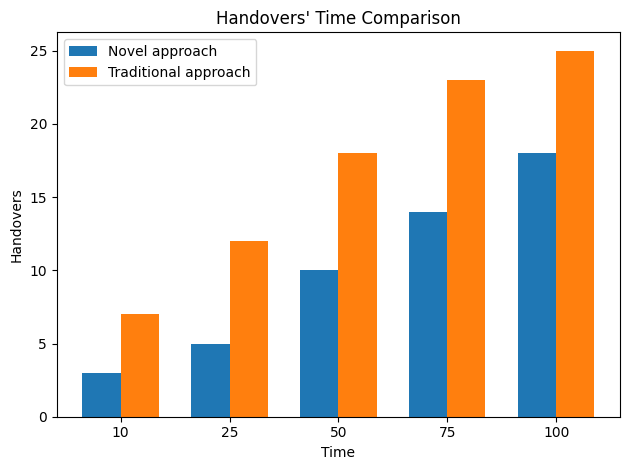

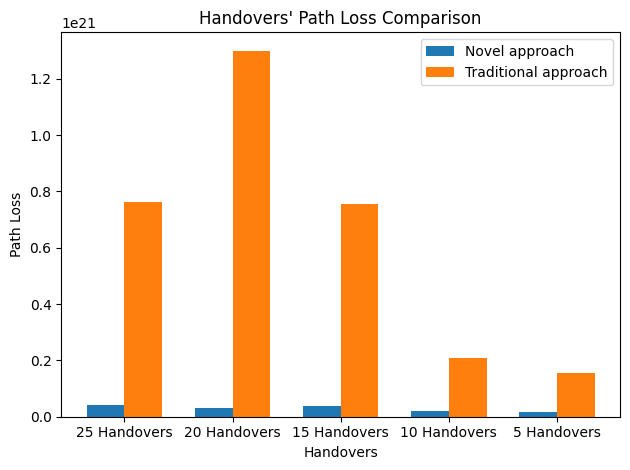

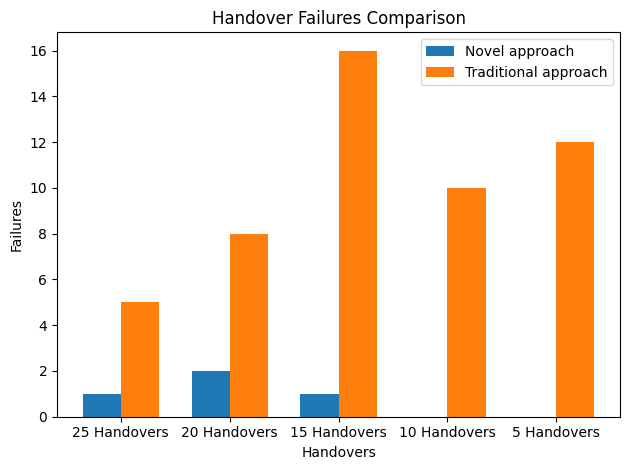

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['10', '25', '50', '75', '100']

y = np.arange(len(labels))
height = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(y - height/2, time_handovers1, height, label='Novel approach')
rects2 = ax.bar(y + height/2, time_handovers2, height, label='Traditional approach')

ax.set_ylabel('Handovers')
ax.set_xlabel('Time')  # Label changed for x-axis
ax.set_title("Handovers' Time Comparison")
ax.set_xticks(y)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()



labels = ['25 Handovers', '20 Handovers', '15 Handovers', '10 Handovers', '5 Handovers']

y = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(y - width/2, total_pathloss1, width, label='Novel approach')
rects2 = ax.bar(y + width/2, total_pathloss2, width, label='Traditional approach')

ax.set_ylabel('Path Loss')
ax.set_xlabel('Handovers')
ax.set_title("Handovers' Path Loss Comparison")
ax.set_xticks(y)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()



labels = ['25 Handovers', '20 Handovers', '15 Handovers', '10 Handovers', '5 Handovers']

y = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(y - width/2, handoverfailures1, width, label='Novel approach')
rects2 = ax.bar(y + width/2, handoverfailures2, width, label='Traditional approach')

ax.set_ylabel('Failures')
ax.set_xlabel('Handovers')
ax.set_title("Handover Failures Comparison")
ax.set_xticks(y)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()